In [17]:
import pandas as pd
import airportsdata

In [18]:
# https://docs.google.com/spreadsheets/d/1qfsGisTjBp-mNvb1urnfKdtw_w438uaQ3gOPd4cKPkA/edit?usp=sharing

url = 'https://docs.google.com/spreadsheets/d/1qfsGisTjBp-mNvb1urnfKdtw_w438uaQ3gOPd4cKPkA/edit?gid=0'
url = url.replace('/edit?gid=', '/export?format=csv&gid=')

df = pd.read_csv(url, quotechar='"', engine="python")

In [19]:
df['Date'] = pd.to_datetime(df['Date'])

date_range = pd.date_range(df['Date'].min() - pd.Timedelta(days=2), df['Date'].max() + pd.Timedelta(days=2))
dates_df = pd.DataFrame({'Date': date_range})

df = dates_df.merge(df, on='Date', how='left')
df = df.set_index('Date')

In [20]:
iata_airports = airportsdata.load('IATA')


def get_latlon(iata):
    if pd.isna(iata):
        return None
    
    else:
        airport = iata_airports[iata]
        return airport['lat'], airport['lon']


df['From (lat, lon)'] = df['From (IATA)'].apply(get_latlon)
df['To (lat, lon)'] = df['To (IATA)'].apply(get_latlon)

In [21]:
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

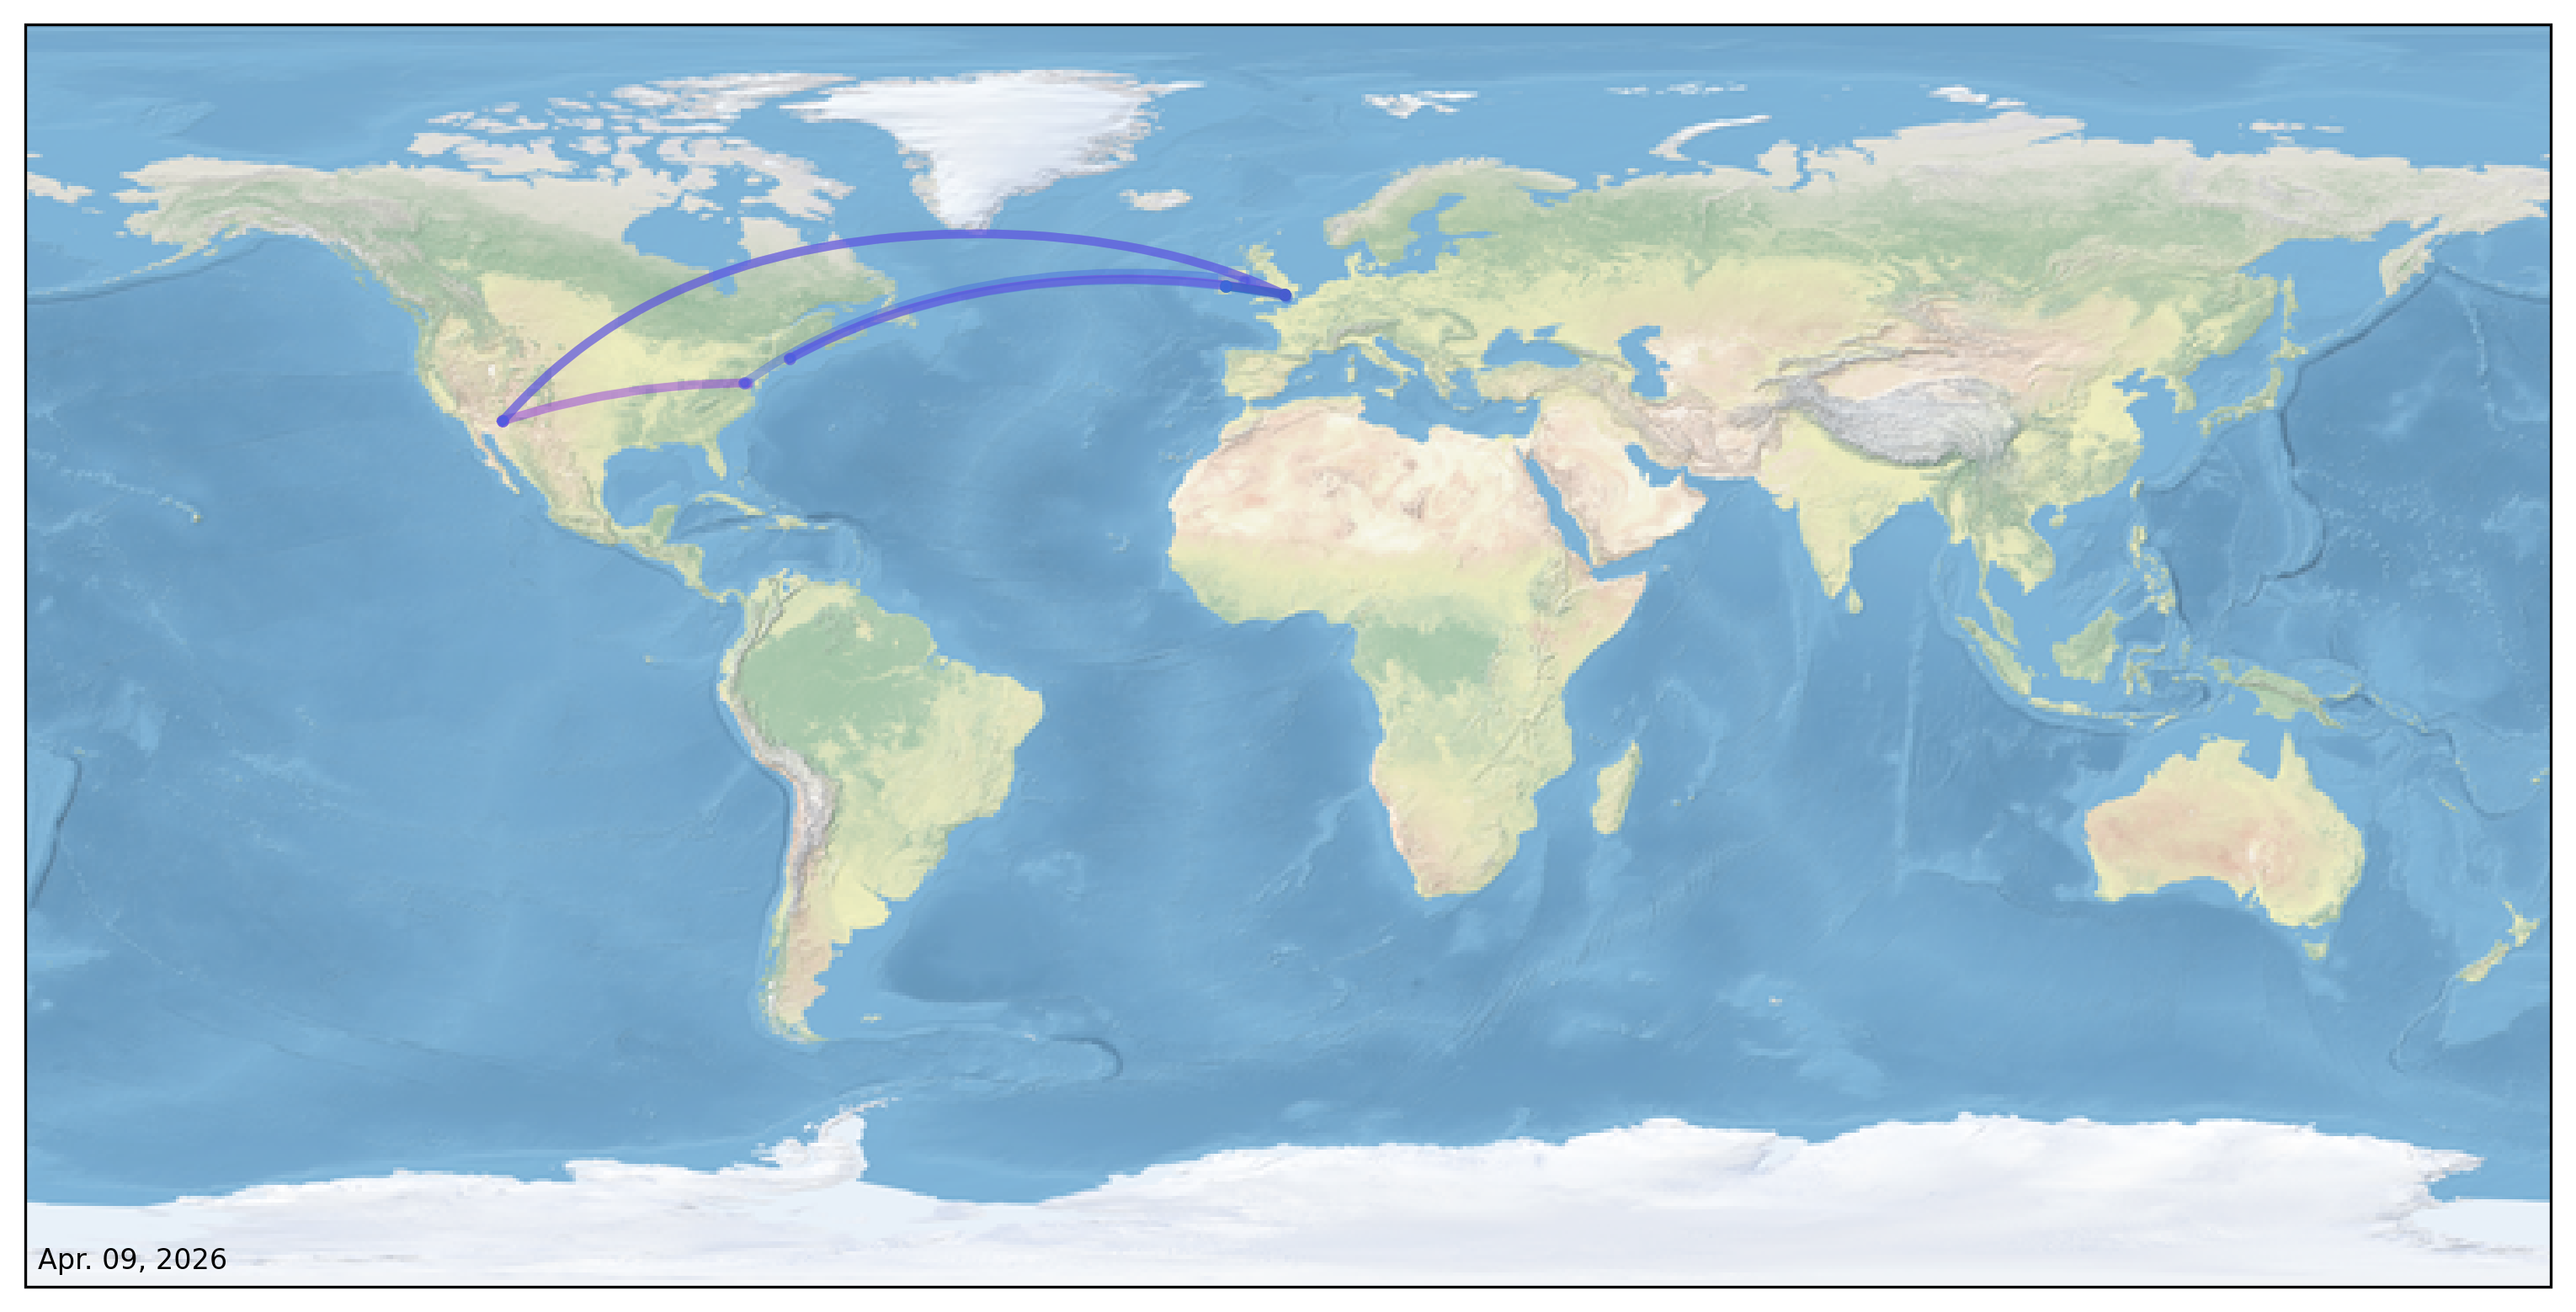

In [23]:
plateCr = ccrs.PlateCarree()
plateCr._threshold /= 10

ax = plt.axes(projection=plateCr)
ax.stock_img()

ax.get_figure().set_size_inches(10, 5)
ax.get_figure().set_dpi(300)
ax.get_figure().subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=None, hspace=None)

color_dict = {'Ben': 'royalblue', 'Lana': 'blueviolet', 'Ben & Lana': 'darkcyan'}
date_text = plt.text(0.005, 0.01, '', ha='left', va='bottom', transform=ax.transAxes, fontsize=8)

unique_dt = df.index.value_counts().sort_index().index

def animate(i):
    dt = df.index.value_counts().sort_index().index[i]
    rows = df.loc[dt]
    
    if isinstance(rows, pd.Series):
        rows = rows.to_frame().T
        
    for i_dt, row in rows.iterrows():
        if not pd.isna(row['Traveler']):
            from_lat, from_lon = row['From (lat, lon)']
            to_lat, to_lon = row['To (lat, lon)']
            color = color_dict[row['Traveler']]
            
            line = ax.plot([from_lon, to_lon], [from_lat, to_lat],
                           color=color, linewidth=2.5, marker='.', markersize=5, alpha=0.25,
                           transform=ccrs.Geodetic())[0]
        date_text.set_text(i_dt.strftime('%b. %d, %Y'))

ani = FuncAnimation(ax.figure, animate, interval=100, frames=len(unique_dt))
ani.save('flights.mp4')
plt.show()